In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import random
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from skimage.io import imread
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [4]:
#Lets import an arcos set, wave data, and the corresponding tracking data...

base_path = Path.cwd().parent / 'Data Sets' / '2023_06_dpi-vs-cgd-ex/'

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(1)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
meta_DF = pd.read_csv(base_path / 'analysis_DF.csv')

um_per_px = meta_DF[meta_DF['File_ID'] == int(image_num)].px_size.values[0]

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

<Axes: xlabel='timepoint', ylabel='circle_radius'>

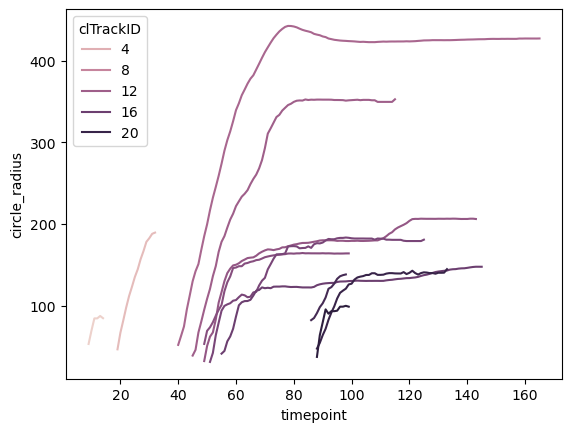

In [5]:
sns.lineplot(data=wave_df, x='timepoint', y='circle_radius', hue='clTrackID')

In [98]:
trains_colors = ['#F5ABB9', '#000000', '#5BCFFA']
train_palette = LinearSegmentedColormap.from_list(colors=trains_colors, name='trains')

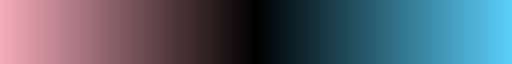

In [99]:
train_palette

In [112]:
#Lets select the example wave:
ex_wave_num = 11
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]
start_time = ex_wave_DF.timepoint.min()
pre_wave_time = start_time - 12 #one min prior to wave
end_time = ex_wave_DF.timepoint.max()
post_wave_time = start_time + 72 #five min after wave starts

In [113]:
#Getting a circle from set: 
ex_time = end_time
vmin_set = 200
vmax_set = 1000
border_color = '#B54845'
border_width = 12
crop_buffer = 220 #Border for cgd 220, DPI 150

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/2.2 #need to convert back from um to px
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

In [114]:
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==end_time].wave_centroid.values[0]
wave_r = ex_wave_DF[ex_wave_DF['timepoint']==end_time].circle_radius.values[0]/um_per_px #need to convert back from um to px


In [115]:
#sample_size = 20000
#track_subset = random.sample(list(tracking_df.track_id.unique()),sample_size)

subset_collect = []

for i, track in tqdm(tracking_df.groupby('track_id')):
    #if i in track_subset:
    track = track[track['timepoint'].between(start_time, post_wave_time)]
    if len(track) > track_min_len:
        #Get the time, x, and y points --> Smooth x and y on time... 
        time = track.timepoint.values*5.0
        x_smooth = UnivariateSpline(time, track.x.values, s=10)
        y_smooth = UnivariateSpline(time, track.y.values, s=10)

        #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
        coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
        lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
        radial_vec = [np.array([wave_center[0] - coords[i][0], wave_center[1] - coords[i][1]]) for i in range(len(coords))]
        dist_from_center = np.linalg.norm(radial_vec, axis=1)*um_per_px
        velocity = np.linalg.norm(lin_velocity_vec, axis=1)*um_per_px*60.0 #px/s --> um/s --> um/min
        angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
        cis = np.cos(angles)
        radial_velocity = velocity*cis

        #Append the relevant parameters to the track: 
        track['radial_dist'] = dist_from_center
        track['radial_movement'] = np.max(dist_from_center) - np.min(dist_from_center)
        track['linear_velocity'] = np.insert(velocity, 0, float('nan'), axis=0)
        track['chemotactic_index'] = np.insert(cis, 0, float('nan'), axis=0)
        track['radial_velocity'] = np.insert(radial_velocity, 0, float('nan'), axis=0)
        track['wave_center_distance'] = dist_from_center
        subset_collect.append(track)

subset_tracks = pd.concat(subset_collect, ignore_index=True)

100%|████████████████████████████████████| 24888/24888 [00:31<00:00, 781.37it/s]


100%|█████████████████████████████████████| 8830/8830 [00:08<00:00, 1049.35it/s]


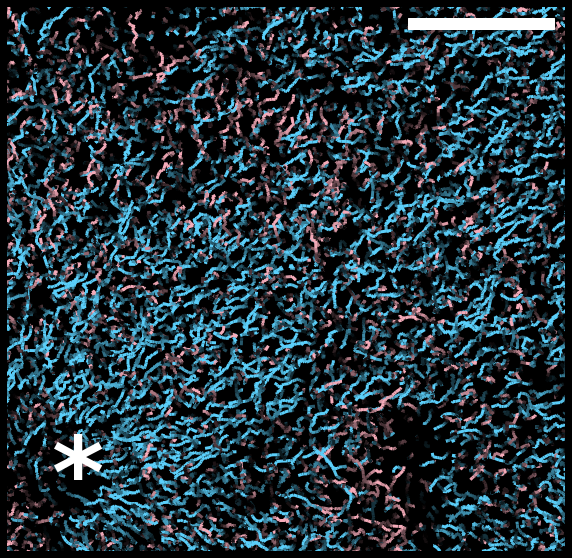

In [116]:
fig, axs = plt.subplots(figsize=(10,10))
#cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

norm = plt.Normalize(-12, 12)
#norm = plt.Normalize(0, 600)
#norm = plt.Normalize(min(subset_tracks.timepoint), max(subset_tracks.timepoint))

for i, track in tqdm(subset_tracks.groupby('track_id')):
    time_pts = track.x.values
    rs = track.y.values
    points = np.array([time_pts, rs]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #chemo_index = track.timepoint.values
    #norm = plt.Normalize(min(chemo_index), max(chemo_index))
    chemo_index = track.radial_velocity.rolling(3).mean()
    
    # Create a continuous norm to map from data points to colors

    lc = LineCollection(segments, cmap=train_palette, norm=norm)
    # Set the values used for colormapping
    lc.set_array(chemo_index)
    lc.set_linewidth(3.0)
    line = axs.add_collection(lc)
    
#plt.imshow(raw_tif[post_wave_time, 0,:,:], cmap='Greys_r', vmin=50, vmax=1400)
#circle1 = plt.Circle(wave_center, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width+1)
#axs.add_patch(circle1)
scalebar = AnchoredSizeBar(axs.transData,
                           100/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=5)

axs.add_artist(scalebar)
fig.set_facecolor("k")
plt.ylim(i_wave_center[1]-crop_buffer,i_wave_center[1]+35) #CGD shift 25, 35 for DPI
plt.xlim(i_wave_center[0]-35,i_wave_center[0]+crop_buffer)
axs.axis('off')
plt.text(i_wave_center[1], i_wave_center[0], '*', color='white', weight='bold', fontsize=100)
plt.gca().invert_yaxis()
plt.savefig('supp5-CGD-tracks-end-of-wave-6min_{}.png'.format(image_num), bbox_inches='tight', dpi=300)